
### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import datetime as dt
import re

In [2]:
df = pd.read_excel(r"E:\datasets\coursera_datasets\online+retail\Online Retail.xlsx")
print("Original Shape:", df.shape)

Original Shape: (541909, 8)


### Preview Data

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Remove Returns (Invoices starting with 'C')

In [4]:
df["InvoiceNo"] = df["InvoiceNo"].astype(str)
df = df[~df["InvoiceNo"].str.startswith("C")]
print("After Removing Returns:", df.shape)

After Removing Returns: (532621, 8)


### Checking Missing Values (NaN) in the Dataset

In [5]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
dtype: int64

### Dropping Rows with Missing Values (NaN)

In [6]:
df.dropna(inplace=True)
df.shape

(397924, 8)

### Checking for Duplicated Rows

In [7]:
df.duplicated().sum()

5192

### Dropping Duplicated Rows

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(392732, 8)

### Visualize Quantity Outliers

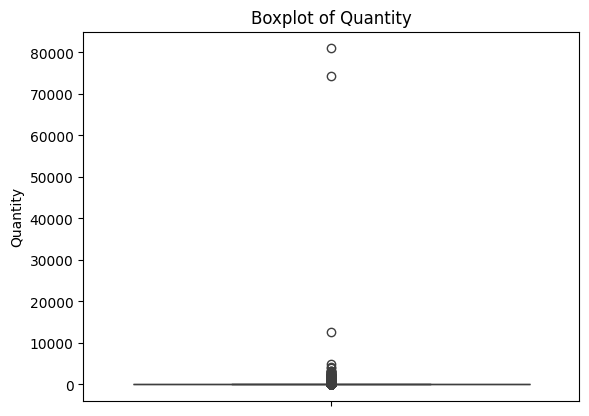

In [9]:
sns.boxplot(df["Quantity"])
plt.title("Boxplot of Quantity")
plt.show()

### Removing Outliers

In [10]:
df = df[df.Quantity <= 5000]
print("After Outlier Removal:", df.shape)

After Outlier Removal: (392729, 8)


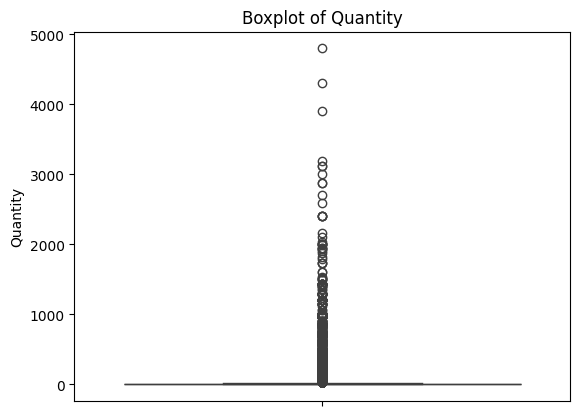

In [11]:
sns.boxplot(df["Quantity"])
plt.title("Boxplot of Quantity")
plt.show()

### Feature Engineering

In [12]:
snapshot_date = df["InvoiceDate"].max() + dt.timedelta(days=1)
df["TotalPurchase"] = df["Quantity"] * df["UnitPrice"]

### Create RFM Table

In [13]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (snapshot_date - x.max()).days,
    "InvoiceNo": "nunique",
    "TotalPurchase": "sum"
}).reset_index()

In [14]:
rfm.columns = ["CustomerID", "Recency", "Frequency", "Monetary"]
rfm

,CustomerID,Recency,Frequency,Monetary
0,12347.0,2,7,4310.00
1,12348.0,75,4,1797.24
2,12349.0,19,1,1757.55
3,12350.0,310,1,334.40
4,12352.0,36,8,2506.04
...,...,...,...,...
4332,18280.0,278,1,180.60
4333,18281.0,181,1,80.82
4334,18282.0,8,2,178.05
4335,18283.0,4,16,2045.53


### Visualize RFM Distributions

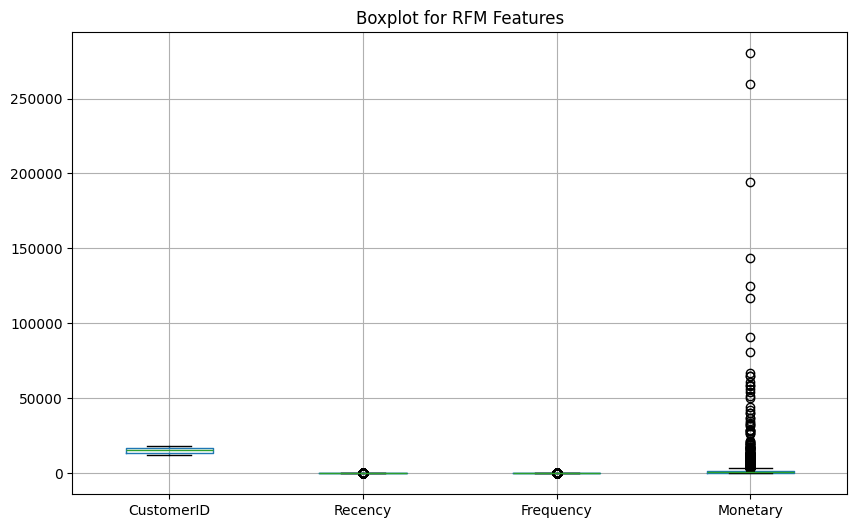

In [15]:
rfm.boxplot(figsize=(10,6))
plt.title("Boxplot for RFM Features")
plt.show()


### Normalize RFM Features

In [16]:
scaler = MinMaxScaler()
rfm_normalized = scaler.fit_transform(rfm[["Recency", "Frequency", "Monetary"]])
rfm_normalized_df = pd.DataFrame(rfm_normalized, columns=["Recency", "Frequency", "Monetary"])

### Use Elbow Method to Find Optimal k

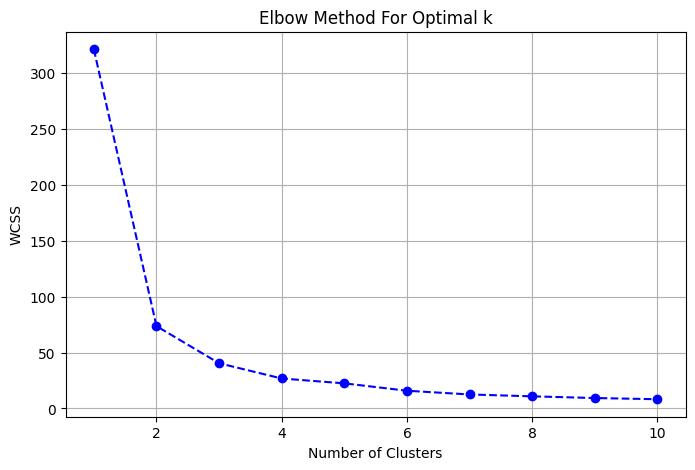

In [17]:
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    kmeans.fit(rfm_normalized_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

###  Apply KMeans Clustering

In [18]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(rfm_normalized_df)
rfm['Cluster'] = cluster_labels

### Evaluate Clustering

In [19]:
score = silhouette_score(rfm_normalized_df, cluster_labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.6456


### Inspect Cluster Averages

In [20]:
cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("\nCluster Summary:\n", cluster_summary.round(1))


Cluster Summary:
          Recency  Frequency  Monetary
Cluster                              
0          153.5        2.2     793.7
1          294.4        1.4     483.2
2           32.2        5.5    2650.3



### Dynamically Label Segments

In [21]:
def assign_segment(row):
    recency = row['Recency']
    frequency = row['Frequency']
    monetary = row['Monetary']

    if recency <= cluster_summary['Recency'].quantile(0.25) and \
       frequency >= cluster_summary['Frequency'].quantile(0.75) and \
       monetary >= cluster_summary['Monetary'].quantile(0.75):
        return 'VIP'
    elif recency >= cluster_summary['Recency'].quantile(0.75) and \
         frequency <= cluster_summary['Frequency'].quantile(0.25):
        return 'At-Risk'
    else:
        return 'Low Spender'

rfm['Segment'] = rfm.apply(assign_segment, axis=1)

In [22]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Cluster,Segment
0,12347.0,2,7,4310.00,2,VIP
1,12348.0,75,4,1797.24,2,VIP
2,12349.0,19,1,1757.55,2,Low Spender
3,12350.0,310,1,334.40,1,At-Risk
4,12352.0,36,8,2506.04,2,VIP



### View Segment Distribution

In [23]:
rfm.Segment.value_counts()

Segment
Low Spender    2972
VIP             865
At-Risk         500
Name: count, dtype: int64


### Final Visualization

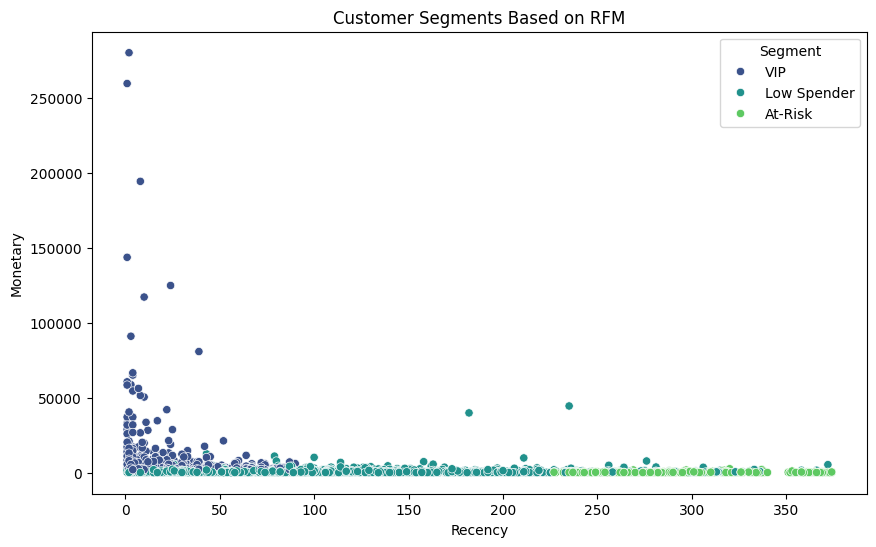

In [24]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='Segment', palette='viridis')
plt.title('Customer Segments Based on RFM')
plt.show()

# Business Interpretation & Insights

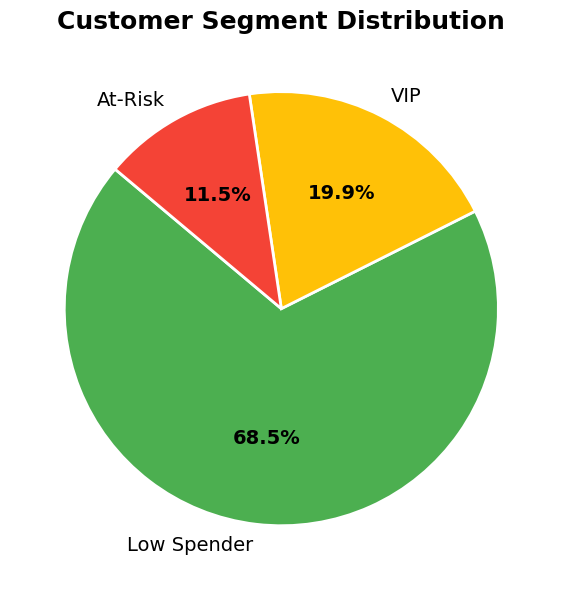

C:\Users\Tanish Sharma\AppData\Local\Temp\ipykernel_4012\4030066958.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=revenue_by_segment.index, y=revenue_by_segment.values, palette='viridis')


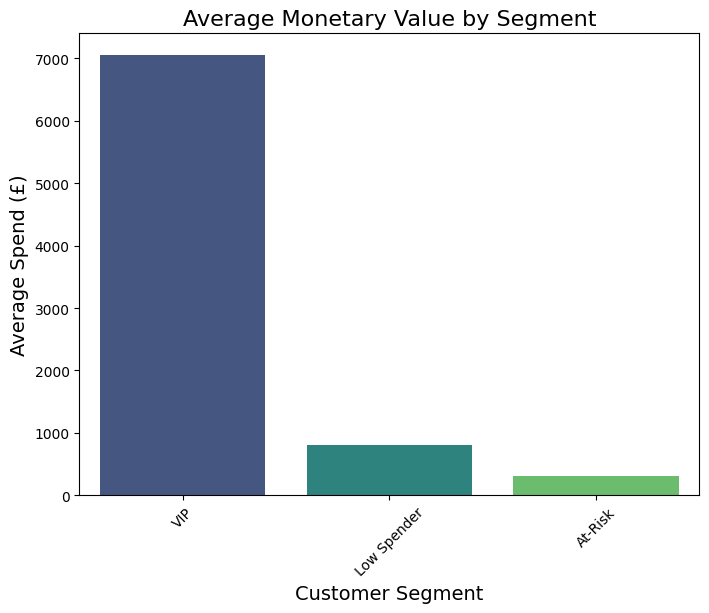


### 📈 Business Interpretation
- **VIPs** are our most valuable customers, contributing the highest average revenue (7047.76)
- **At-Risk** customers are those who haven't shopped recently and buy less frequently — need reactivation strategies.
- **Low Spenders** are the majority — opportunity to upsell/cross-sell.

### 🧠 Business Actions
- 🎁 **Reward VIPs** with loyalty programs.
- 🔁 **Re-engage At-Risk** with personalized offers.
- 📈 **Upsell Low Spenders** by recommending bundles or discounts.

---


In [25]:
# 📊 Visualizing Customer Segments

import seaborn as sns
import matplotlib.pyplot as plt

# Segment Distribution - Pie Chart
segment_counts = rfm['Segment'].value_counts()

colors = ['#4CAF50', '#FFC107', '#F44336']  # Green for VIPs, Yellow for At-Risk, Red for Low Spenders

plt.figure(figsize=(8,6))
wedges, texts, autotexts = plt.pie(
    segment_counts, 
    labels=segment_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14, 'color': 'black'},
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)

plt.setp(autotexts, size=14, weight="bold")
plt.title('Customer Segment Distribution', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.show()

# Revenue Contribution by Segment - Bar Plot
revenue_by_segment = rfm.groupby('Segment')['Monetary'].mean().sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(x=revenue_by_segment.index, y=revenue_by_segment.values, palette='viridis')
plt.title('Average Monetary Value by Segment', fontsize=16)
plt.ylabel('Average Spend (£)', fontsize=14)
plt.xlabel('Customer Segment', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 📋 Summary Insights (as Text)
from IPython.display import display, Markdown

summary_text = """
### 📈 Business Interpretation
- **VIPs** are our most valuable customers, contributing the highest average revenue (€ 7047.76)
- **At-Risk** customers are those who haven't shopped recently and buy less frequently — need reactivation strategies.
- **Low Spenders** are the majority — opportunity to upsell/cross-sell.

### 🧠 Business Actions
- 🎁 **Reward VIPs** with loyalty programs.
- 🔁 **Re-engage At-Risk** with personalized offers.
- 📈 **Upsell Low Spenders** by recommending bundles or discounts.

---
"""

display(Markdown(summary_text))
